##### This notebook will contain code for our feature importance analysis for this dataset. Since, we noted that the Random Forest did the best for prediction this will be our base model for this section. We will utilize both the inbuilt feature importance attribute of the R.F as well as use permutation testing. Hopefully, we will see aligment between the most important features here. 

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, average_precision_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt



In [64]:
df=pd.read_csv("./processed_df.csv")
df=df.drop(columns=["Unnamed: 0"])

In [65]:
X = df.drop(columns=["accepted"])
y = df["accepted"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
min,max=np.min(X_train,axis=0),np.max(X_train,axis=0)
X_train,X_val,X_test=((X_train-min)/(max-min)).values,((X_val-min)/(max-min)).values,(((X_test-min)/(max-min)).values)
y_train,y_val,y_test=y_train.values,y_val.values,y_test.values


In [94]:
best_param_dict={'max_features': 'sqrt',
  'max_depth': 10,
  'n_estimators': 100,
  'criterion': 'entropy',
  'class_weight': 'balanced'}

final_model = RandomForestClassifier(**best_param_dict, random_state=42)
final_model.fit(np.concatenate([X_train,X_val],axis=0),np.concatenate([y_train,y_val],axis=0))
# Get feature importances importances
final_model.feature_importances_
feature_importance_dict=dict(zip(X.columns,final_model.feature_importances_))

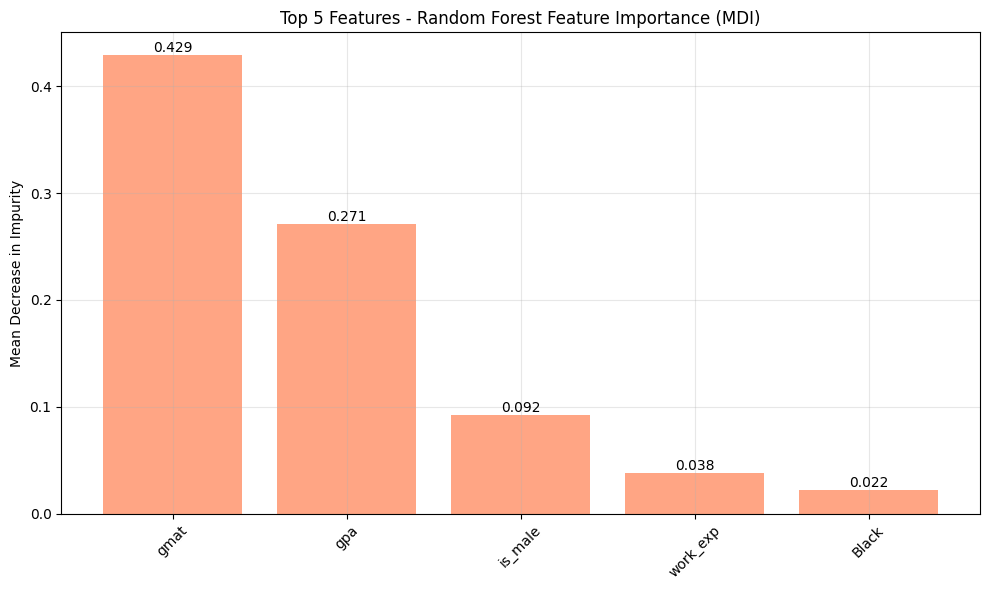

In [95]:
# Convert dict to DataFrame and sort
# used chatgpt to make nice plot
rf_importance_df = pd.DataFrame({
   'feature': feature_importance_dict.keys(),
   'importance': feature_importance_dict.values()
}).sort_values('importance', ascending=False)

# Get top 5
rf_top5 = rf_importance_df.head(5)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(rf_top5['feature'], rf_top5['importance'], color='coral', alpha=0.7)
ax.set_title('Top 5 Features - Random Forest Feature Importance (MDI)')
ax.set_ylabel('Mean Decrease in Impurity')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of bars
for bar in bars:
   height = bar.get_height()
   ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.3f}',
           ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [89]:
scoring = {
    'f1': make_scorer(f1_score),
    'auc': make_scorer(roc_auc_score),
    'auprc': make_scorer(average_precision_score)
}
r = permutation_importance(
    final_model, 
    X_test, 
    y_test,
    n_repeats=25,
    random_state=42,
    scoring=scoring
)
importance_dfs = {}
for metric in scoring.keys():
    importance_dfs[metric] = pd.DataFrame({
        'feature': X.columns,
        'importance': r[metric].importances_mean,
        'std': r[metric].importances_std          
    }).sort_values('importance', ascending=False)

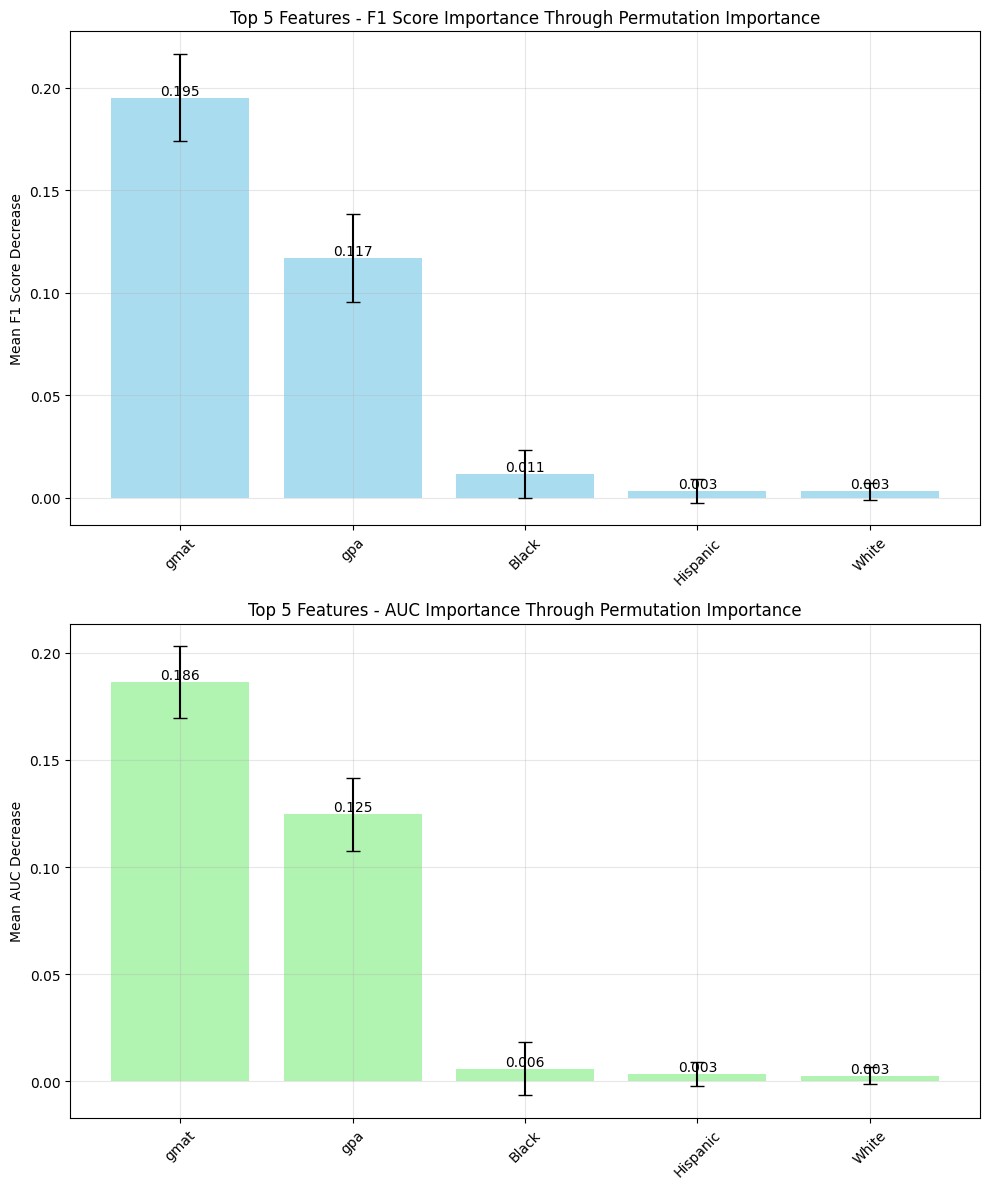

In [91]:
# used chatgpt to make nice plot

f1_top5 = importance_dfs['f1'].head(5)
auc_top5 = importance_dfs['auc'].head(5)

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot F1 Score importances
bars1 = ax1.bar(f1_top5['feature'], f1_top5['importance'], yerr=f1_top5['std'], 
                capsize=5, color='skyblue', alpha=0.7)
ax1.set_title('Top 5 Features - F1 Score Importance Through Permutation Importance')
ax1.set_ylabel('Mean F1 Score Decrease')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot AUC importances
bars2 = ax2.bar(auc_top5['feature'], auc_top5['importance'], yerr=auc_top5['std'],
                capsize=5, color='lightgreen', alpha=0.7)
ax2.set_title('Top 5 Features - AUC Importance Through Permutation Importance')
ax2.set_ylabel('Mean AUC Decrease')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

add_value_labels(ax1, bars1)
add_value_labels(ax2, bars2)

plt.tight_layout()
plt.show()